**Importing Libraries**

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from keras.layers import *
from keras.models import Model
import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.losses import categorical_crossentropy
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_prep
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

**Reading DataFrame**

In [2]:
df=pd.read_csv('../input/100-bird-species/birds.csv',dtype=str)
df.head()

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


**Correcting File paths**

In [3]:
app="../input/100-bird-species/"
for index,row in tqdm(df.iterrows()):
    row['filepaths']=app+row['filepaths']

62388it [00:04, 14371.91it/s]


**Preparing Data Pipelines using Flow_from_Dataframe. We will use only 2 columns filepaths and labels and as per the documentation column names must be filename and class hence renaming of columns is required. Also Augmentation is performed on only train data.**

In [9]:
# Training Data generator
train_df=df.loc[df['data set']=='train']
train_df1=train_df[['filepaths','labels']]
train_df1.rename(columns = {'filepaths':'filename','labels':'class'}, inplace = True)
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,width_shift_range=[0.5,1.5],height_shift_range=[0.5,1.5],
                              rotation_range=45,brightness_range=[0.5,1.5],horizontal_flip=True,shear_range=45,zoom_range=[0.5,1.5],preprocessing_function=vgg19_prep)
train_gen = ImageFlow.flow_from_dataframe(dataframe=train_df1,target_size=(224,224),seed=10,batch_size=512)

Found 58388 validated image filenames belonging to 400 classes.


In [8]:
# Validation Data Generator
valid_df=df.loc[df['data set']=='valid']
valid_df1=valid_df[['filepaths','labels']]
valid_df1.rename(columns = {'filepaths':'filename','labels':'class'}, inplace = True)
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,preprocessing_function=vgg19_prep)
validation_gen = ImageFlow.flow_from_dataframe(dataframe=valid_df1,target_size=(224,224),seed=10,batch_size=512,shuffle=False)

Found 2000 validated image filenames belonging to 400 classes.


In [4]:
# Test Data Generator
test_df=df.loc[df['data set']=='test']
test_df1=test_df[['filepaths','labels']]
test_df1.rename(columns = {'filepaths':'filename','labels':'class'}, inplace = True)
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,preprocessing_function=vgg19_prep)
test_gen = ImageFlow.flow_from_dataframe(dataframe=test_df1,target_size=(224,224),seed=10,batch_size=512,shuffle=False)

Found 2000 validated image filenames belonging to 400 classes.


**Loading Pretrained VGG19 Model without its last layer**

In [9]:
base_model = tf.keras.applications.VGG19(input_shape = (224, 224, 3),
include_top = False, 
weights = 'imagenet')

2022-06-14 12:03:21.481797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 12:03:21.572117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 12:03:21.572859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 12:03:21.573945: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False

**Adding last layer for classification**

In [12]:
tf.keras.backend.clear_session()
x = Flatten()(base_model.output)
output_layer = Dense(units=400,activation="softmax")(x)
model = tf.keras.models.Model(base_model.input, output_layer)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

**Defining Callbacks for learning rate and early stopping**

In [13]:
c1=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, min_delta=0.01)

In [14]:
class Custom_call(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.valacc=[]
    def on_epoch_end(self, epoch, logs={}): 
        
        self.valacc.append(logs.get('val_accuracy'))
        if (epoch==0 or epoch==1):
            pass
        if  self.valacc[epoch]>= self.valacc[epoch-1]:
            self.model.optimizer.lr=self.model.optimizer.lr-(0.05*self.model.optimizer.lr)
        
c2=Custom_call() 

In [15]:
hist1 = model.fit(train_gen,steps_per_epoch=len(train_gen),validation_data=validation_gen,validation_steps=len(validation_gen),epochs=20,callbacks=[c1,c2])

2022-06-14 12:05:22.847414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-14 12:05:35.082935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-06-14 12:05:39.557569: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


115/115 [==============================] - 1373s 12s/step - loss: 4.9198 - accuracy: 0.1489 - val_loss: 2.2722 - val_accuracy: 0.5030
Epoch 2/20
115/115 [==============================] - 876s 8s/step - loss: 3.3747 - accuracy: 0.3167 - val_loss: 1.4547 - val_accuracy: 0.6670
Epoch 3/20
115/115 [==============================] - 872s 8s/step - loss: 2.9772 - accuracy: 0.3817 - val_loss: 1.1782 - val_accuracy: 0.7115
Epoch 4/20
115/115 [==============================] - 873s 8s/step - loss: 2.7302 - accuracy: 0.4206 - val_loss: 1.0969 - val_accuracy: 0.7425
Epoch 5/20
115/115 [==============================] - 876s 8s/step - loss: 2.5213 - accuracy: 0.4559 - val_loss: 1.3851 - val_accuracy: 0.7180
Epoch 6/20
115/115 [==============================] - 886s 8s/step - loss: 2.4680 - accuracy: 0.4703 - val_loss: 0.9332 - val_accuracy: 0.7795
Epoch 7/20
115/115 [==============================] - 904s 8s/step - loss: 2.2864 - accuracy: 0.4998 - val_loss: 0.8511 - val_accuracy: 0.7910
Epoch 8/

In [17]:
model.save('bestvgg19.h5')

**Visualizing Loss and Accuarcy**

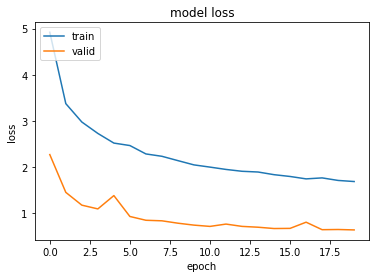

In [18]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

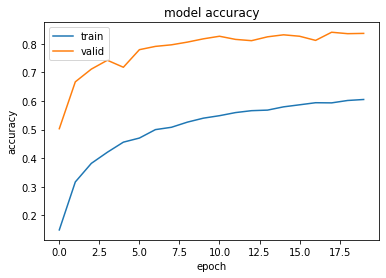

In [19]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**Evaluation and Predictions of test set**

In [5]:
model=keras.models.load_model('../input/bestvgg/bestvgg19.h5')
#model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

2022-06-15 08:48:44.279326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 08:48:44.396301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 08:48:44.397248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 08:48:44.398554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
model.evaluate(test_gen)

2022-06-15 08:49:00.831375: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-15 08:49:04.024544: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-06-15 08:49:08.236777: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


4/4 [==============================] - 71s 11s/step - loss: 0.5017 - accuracy: 0.8775


[0.5016878247261047, 0.8774999976158142]

**Predicting given Images**

In [10]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

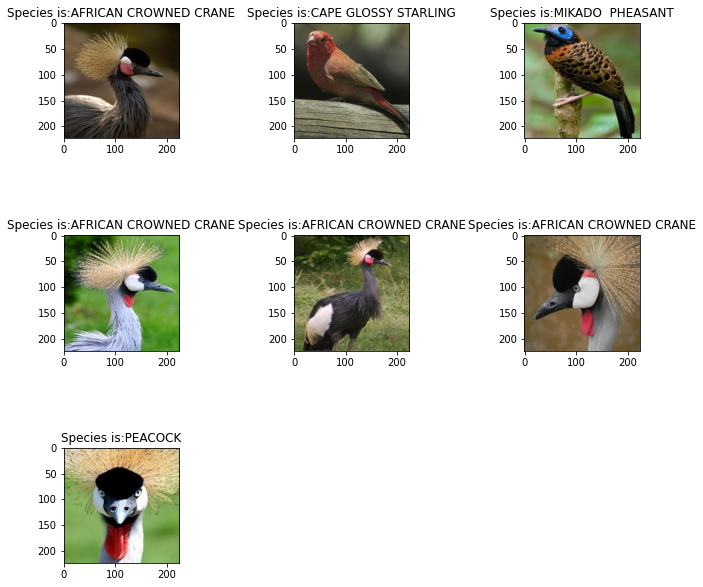

In [11]:
count=1
plt.subplots(figsize=(10,10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.4)

for i in os.listdir('../input/100-bird-species/images to test'):
    image = tf.keras.utils.load_img('../input/100-bird-species/images to test/'+i,target_size=(224,224)) 
    img = tf.keras.utils.img_to_array(image)
    img = np.expand_dims(img, axis=0) 
    prediction = model.predict(img)
    ind=np.argmax(prediction,axis=1)
    plt.subplot(3,3,count)
    plt.title('Species is:'+str(labels[ind[0]]))
    plt.imshow(image)
    count+=1
    

In [15]:
list(test_df['filepaths'])[7]

'../input/100-bird-species/test/ABBOTTS BOOBY/3.jpg'

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [19]:
img = load_img('../input/100-bird-species/test/ABBOTTS BOOBY/3.jpg', target_size=(224,224))
print('\033[1m' +"Actual Species:ABBOTTS BOOBY")
img = img_to_array(img) 
img = vgg19_prep(img)
img = np.expand_dims(img, axis=0)  
prediction = model.predict(img)
sorted_preds = np.sort(prediction)[0][::-1]
top5 = np.argsort(prediction)[0][::-1][:5]
print('\033[1m' +"5 species & the probabilities according to model")
for i in range(len(top5preds)):
    pred_species = labels.get(top5preds[i])
    text = pred_species + ":" + str(sorted_preds[i])
    print('\033[1m' ,text)

Actual Species:ABBOTTS BOOBY
5 species & the probabilities according to model
 BANDED PITA:1.0
 YELLOW HEADED BLACKBIRD:0.0
 CRIMSON CHAT:0.0
 CRANE HAWK:0.0
 CREAM COLORED WOODPECKER:0.0
